# 2. BFSI CASE STUDY

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE


In [3]:
import pandas as pd
applications = pd.read_csv('/content/drive/MyDrive/Upgrad_Projects /applications_base.csv')
bureau = pd.read_csv('/content/drive/MyDrive/Upgrad_Projects /bureau.csv')

In [ ]:
# Check for missing values in the applications dataset
print("Missing values in applications dataset:")
print(applications.isnull().sum())

# Check for missing values in the bureau dataset
print("\nMissing values in bureau dataset:")
print(bureau.isnull().sum())

Missing values in applications dataset:
SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

Missing values in bureau dataset:
SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                

In [ ]:
# Handle missing values in applications dataset
applications.fillna(0, inplace=True)

# Handle missing values in bureau dataset
bureau.fillna(0, inplace=True)

In [ ]:
# Check for missing values in the applications dataset
print("Missing values in applications dataset:")
print(applications.isnull().sum())

# Check for missing values in the bureau dataset
print("\nMissing values in bureau dataset:")
print(bureau.isnull().sum())

Missing values in applications dataset:
SK_ID_CURR                    0
TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 122, dtype: int64

Missing values in bureau dataset:
SK_ID_CURR                0
SK_ID_BUREAU              0
CREDIT_ACTIVE             0
CREDIT_CURRENCY           0
DAYS_CREDIT               0
CREDIT_DAY_OVERDUE        0
DAYS_CREDIT_ENDDATE       0
DAYS_ENDDATE_FACT         0
AMT_CREDIT_MAX_OVERDUE    0
CNT_CREDIT_PROLONG        0
AMT_CREDIT_SUM            0
AMT_CREDIT_SUM_DEBT       0
AMT_CREDIT_SUM_LIMIT      0
AMT_CREDIT_SUM_OVERDUE    0
CREDIT_TYPE               0
DAYS_CREDIT_UPDATE        0
AMT_ANNUITY               0
dtype: int64


In [ ]:
# Feature engineering on bureau dataset
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'SK_ID_BUREAU': 'count',  # Number of trades reported in bureau
    'CREDIT_ACTIVE': lambda x: sum(x == 'Active'),  # Number of active trades
    'CREDIT_DAY_OVERDUE': 'max',  # Max_CREDIT_DAY_OVERDUE
    'CREDIT_CURRENCY': lambda x: x.mode()[0]  # Most frequent currency
}).reset_index().rename(columns={
    'SK_ID_BUREAU': 'NUM_TRADES_REPORTED',
    'CREDIT_ACTIVE': 'NUM_ACTIVE_TRADES',
    'CREDIT_DAY_OVERDUE': 'MAX_CREDIT_DAY_OVERDUE',
    'CREDIT_CURRENCY': 'MOST_FREQUENT_CURRENCY'
})


In [ ]:
# Merge applications and bureau_agg datasets
merged_data = applications.merge(bureau_agg, on='SK_ID_CURR', how='left')


In [ ]:
# Drop columns with high percentage of missing values
missing_data_threshold = 0.3  # Adjust threshold as per requirement
high_missing_cols = [col for col in applications.columns if applications[col].isnull().mean() > missing_data_threshold]
applications.drop(columns=high_missing_cols, inplace=True)

# Fill missing values for numeric data with median and for categorical with mode
for col in applications.columns:
    if applications[col].dtype == 'object':
        applications[col].fillna(applications[col].mode()[0], inplace=True)
    else:
        applications[col].fillna(applications[col].median(), inplace=True)

# Repeat for bureau data
high_missing_cols = [col for col in bureau.columns if bureau[col].isnull().mean() > missing_data_threshold]
bureau.drop(columns=high_missing_cols, inplace=True)

for col in bureau.columns:
    if bureau[col].dtype == 'object':
        bureau[col].fillna(bureau[col].mode()[0], inplace=True)
    else:
        bureau[col].fillna(bureau[col].median(), inplace=True)

print("\nCleaned Applications Data:")
print(applications.head())
print("\nCleaned Bureau Data:")
print(bureau.head())



Cleaned Applications Data:
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...   

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Preparing data
numeric_cols = applications.select_dtypes(include=[np.number]).columns.tolist()
X = applications[numeric_cols].drop(columns=['TARGET'])
y = applications['TARGET']

# Fill any remaining NaNs
X.fillna(X.mean(), inplace=True)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Check the balance
print('After SMOTE, counts of label \'1\': {}'.format(sum(y_train_smote == 1)))
print('After SMOTE, counts of label \'0\': {}'.format(sum(y_train_smote == 0)))


After SMOTE, counts of label '1': 226132
After SMOTE, counts of label '0': 226132


In [ ]:
# Aggregating bureau data
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'SK_ID_BUREAU': 'count',
    'CREDIT_ACTIVE': lambda x: x.value_counts().index[0],
    'CREDIT_DAY_OVERDUE': 'max',
    'CREDIT_CURRENCY': lambda x: x.mode()[0]
}).rename(columns={
    'SK_ID_BUREAU': 'number_of_trades',
    'CREDIT_ACTIVE': 'most_frequent_credit_active',
    'CREDIT_DAY_OVERDUE': 'max_credit_day_overdue',
    'CREDIT_CURRENCY': 'most_frequent_currency'
})

# Merging aggregated bureau data with applications data
applications = applications.merge(bureau_agg, on='SK_ID_CURR', how='left')

print("\nCombined Data Preview:")
print(applications.head())



Combined Data Preview:
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0  ...                      

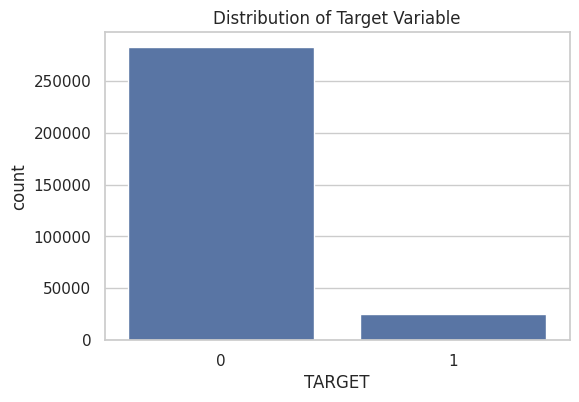

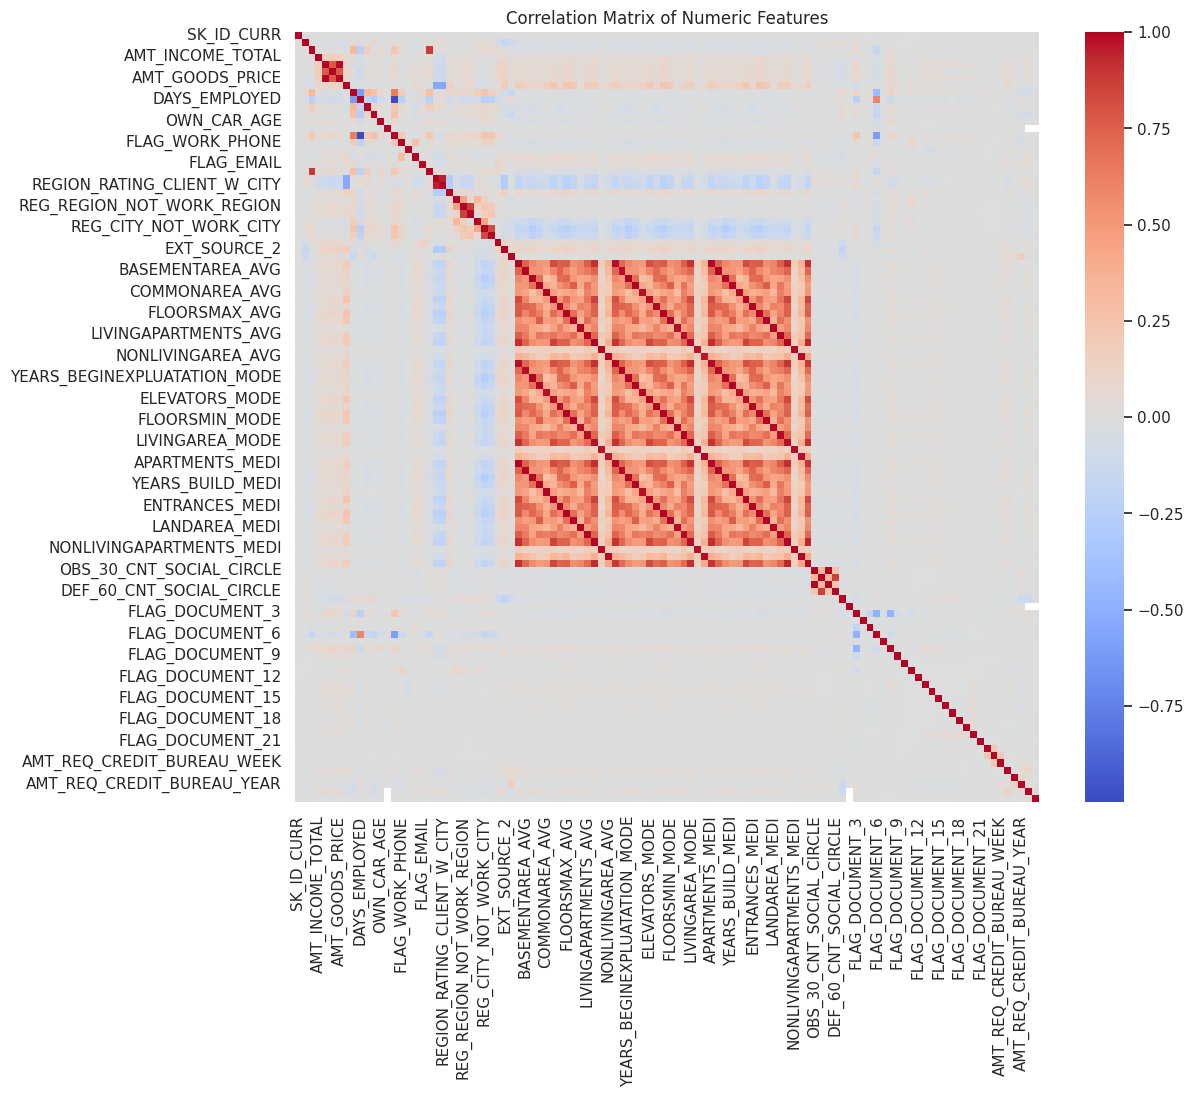

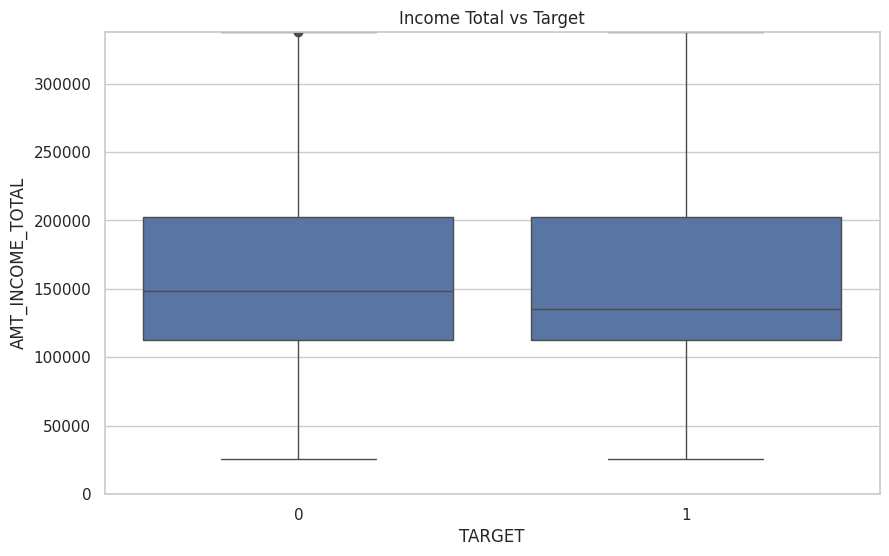

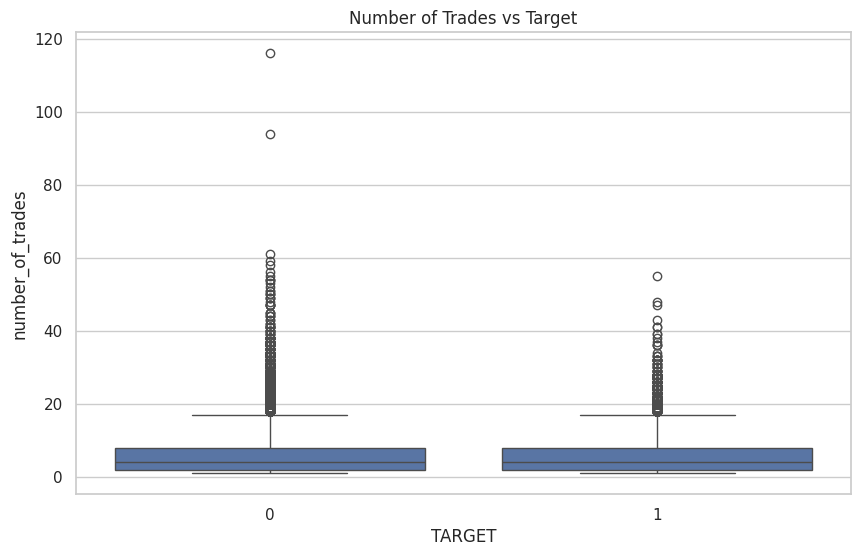

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Exploring the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='TARGET', data=applications)
plt.title('Distribution of Target Variable')
plt.show()

# Filtering out non-numeric columns
numeric_columns = applications.select_dtypes(include=[np.number]).columns
corr_matrix = applications[numeric_columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()


# Examining some specific relationships
plt.figure(figsize=(10, 6))
sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=applications)
plt.title('Income Total vs Target')
plt.ylim(0, applications['AMT_INCOME_TOTAL'].quantile(0.95))  # Limiting outlier influence
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='TARGET', y='number_of_trades', data=applications)
plt.title('Number of Trades vs Target')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Prepare data for modeling
# Drop non-numeric columns for simplicity in this example
numeric_cols = applications.select_dtypes(include=[np.number]).columns.tolist()
X = applications[numeric_cols].drop(columns=['TARGET'])
y = applications['TARGET']

# Fill any remaining NaNs
X.fillna(X.mean(), inplace=True)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Check the balance
print('After SMOTE, counts of label \'1\': {}'.format(sum(y_train_smote == 1)))
print('After SMOTE, counts of label \'0\': {}'.format(sum(y_train_smote == 0)))


After SMOTE, counts of label '1': 226132
After SMOTE, counts of label '0': 226132


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='newton-cg'),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
}

# Dictionary to store results
model_results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    model_results[name] = {"ROC AUC": roc_auc, "Accuracy": accuracy, "Report": report}
    print(f"{name} trained.")

# Display results
for model_name, results in model_results.items():
    print(f"\n{model_name} - ROC AUC: {results['ROC AUC']}, Accuracy: {results['Accuracy']}")
    print(f"Classification Report:\n{results['Report']}")


Logistic Regression trained.
Decision Tree trained.
Random Forest trained.

Logistic Regression - ROC AUC: 0.7213064826816868, Accuracy: 0.670016096775767
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56554
           1       0.15      0.65      0.24      4949

    accuracy                           0.67     61503
   macro avg       0.55      0.66      0.52     61503
weighted avg       0.89      0.67      0.75     61503


Decision Tree - ROC AUC: 0.5442990923160481, Accuracy: 0.822642797912297
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90     56554
           1       0.13      0.21      0.16      4949

    accuracy                           0.82     61503
   macro avg       0.53      0.54      0.53     61503
weighted avg       0.86      0.82      0.84     61503


Random Forest - ROC AUC: 0.7093542127007784, Accuracy: 0.9135977106807

The Graph Indicates the importance of all of the variables that is usefull for recommendations.